In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

%matplotlib inline

## Data Import

한국주식: KRX 100 지수 구성종목

미국주식: S&P 100 지수 구성종목

전체 200개 종목에 대해 최근 5년치 주가데이터가 존재하는 189개 종목 대상

주가데이터는 'prices' 시트, 속성정보는 'attributes' 시트

속성으로는 업종(sector)과 국가

업종은 GICS(글로벌산업분류기준) 11개 섹터

In [3]:
# price data load
df = pd.read_excel('./sna_capstone.xlsx', sheet_name = 'prices') 
df = df.set_index('Date')

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1300 entries, 2016-05-27 to 2021-05-20
Columns: 189 entries, 010130 to TSLA
dtypes: float64(97), int64(92)
memory usage: 1.9 MB


,010130,051910,005490,128940,095700,011170,006400,036570,011780,035420,...,AMGN,HD,NKE,CAT,CVX,BA,COST,GS,CHTR,TSLA
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-27,480500,275000,208500,529268,56500,292500,108000,234000,63600,140000,...,156.74,133.94,56.19,71.96,102.02,129.22,149.08,159.53,219.97,44.608
2016-05-30,473000,273000,208000,536176,58000,283000,107000,239000,63000,142000,...,156.74,133.94,56.19,71.96,102.02,129.22,149.08,159.53,219.97,44.608
2016-05-31,469500,271000,208000,546537,61000,284000,112500,240500,63800,144000,...,157.95,132.12,55.22,72.51,101.00,126.15,148.77,159.48,218.94,44.646
2016-06-01,473500,269500,209000,551717,62800,277500,117000,233500,61900,137400,...,158.05,131.83,54.93,72.27,101.13,126.41,152.52,159.97,227.50,43.912
2016-06-02,477500,269000,205500,550854,62700,279000,118000,230500,61200,139400,...,159.87,132.41,54.53,73.62,100.53,126.85,151.51,159.28,227.82,43.792


In [4]:
attr = pd.read_excel('./sna_capstone_kr.xlsx', sheet_name = 'attributes') 

attr.info()

attr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       189 non-null    object
 1   name     189 non-null    object
 2   sector   189 non-null    object
 3   country  189 non-null    object
dtypes: object(4)
memory usage: 6.0+ KB


,id,name,sector,country
0,010130,고려아연,소재,한국
1,051910,LG화학,소재,한국
2,005490,포스코,소재,한국
3,128940,한미약품,건강관리,한국
4,095700,제넥신,건강관리,한국


# Edglist 형태로 변환

In [5]:
## 전체 대상
# log return
ret = df.pct_change().dropna()
ret = np.log(1+ret)

ret.head()

# correlation matrix
corr = ret.corr()

corr.head()

# correlation to distance/weight
hurdle = 0.3 # correlation hurdle
thres = np.sqrt((1.-hurdle)*2) # threshold distance 

dist = np.sqrt(np.clip((1.-corr)*2., a_min=0.0, a_max=4.0))
dist[dist>thres] = 0

weight = 1./dist
weight = weight.replace([np.inf, -np.inf], 0.)

weight.head()

,010130,051910,005490,128940,095700,011170,006400,036570,011780,035420,...,AMGN,HD,NKE,CAT,CVX,BA,COST,GS,CHTR,TSLA
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-30,-0.015732,-0.007299,-0.002401,0.012968,0.026202,-0.033018,-0.009302,0.021142,-0.009479,0.014185,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-05-31,-0.007427,-0.007353,0.000000,0.019140,0.050431,0.003527,0.050124,0.006257,0.012618,0.013986,...,0.007690,-0.013681,-0.017414,0.007614,-0.010048,-0.024045,-0.002082,-0.000313,-0.004693,0.000852
2016-06-01,0.008484,-0.005550,0.004796,0.009433,0.029081,-0.023153,0.039221,-0.029538,-0.030233,-0.046917,...,0.000633,-0.002197,-0.005266,-0.003315,0.001286,0.002059,0.024894,0.003068,0.038353,-0.016577
2016-06-02,0.008412,-0.001857,-0.016888,-0.001565,-0.001594,0.005391,0.008511,-0.012931,-0.011373,0.014451,...,0.011450,0.004390,-0.007309,0.018508,-0.005951,0.003475,-0.006644,-0.004323,0.001406,-0.002736
2016-06-03,0.000000,-0.024460,-0.012240,0.006249,-0.011227,-0.032790,-0.056660,0.004329,0.017814,0.014245,...,-0.004263,-0.005073,-0.020004,0.019105,0.001292,0.004169,0.001319,-0.022925,-0.012678,0.000137


,010130,051910,005490,128940,095700,011170,006400,036570,011780,035420,...,AMGN,HD,NKE,CAT,CVX,BA,COST,GS,CHTR,TSLA
010130,1.000000,0.291664,0.391087,0.161324,0.147365,0.318630,0.217951,0.154128,0.188698,0.148376,...,0.103394,0.132261,0.124322,0.146014,0.189295,0.156901,0.016806,0.140545,0.103473,0.067270
051910,0.291664,1.000000,0.331077,0.204597,0.271813,0.444341,0.608378,0.218886,0.337443,0.264165,...,0.084228,0.129299,0.157159,0.114569,0.187409,0.171286,0.069619,0.142699,0.071101,0.112178
005490,0.391087,0.331077,1.000000,0.152532,0.138248,0.440768,0.191680,0.070129,0.283307,0.136021,...,0.035086,0.086533,0.112692,0.131182,0.167093,0.172375,-0.004557,0.133365,0.049888,0.050260
128940,0.161324,0.204597,0.152532,1.000000,0.367332,0.143521,0.231422,0.140332,0.153097,0.162411,...,0.103299,0.040625,0.053634,0.068699,0.065246,0.104154,0.027790,0.032782,0.027328,0.046466
095700,0.147365,0.271813,0.138248,0.367332,1.000000,0.231533,0.274963,0.167418,0.168840,0.223376,...,0.087769,0.059235,0.087337,0.062670,0.082843,0.068416,0.059331,0.014442,0.073030,0.059594


,010130,051910,005490,128940,095700,011170,006400,036570,011780,035420,...,AMGN,HD,NKE,CAT,CVX,BA,COST,GS,CHTR,TSLA
010130,0.000000,0.000000,0.906165,0.000000,0.000000,0.856631,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
051910,0.000000,0.000000,0.864564,0.000000,0.000000,0.948595,1.12993,0.0,0.868707,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
005490,0.906165,0.864564,0.000000,0.000000,0.000000,0.945560,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128940,0.000000,0.000000,0.000000,0.000000,0.888991,0.000000,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
095700,0.000000,0.000000,0.000000,0.888991,0.000000,0.000000,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# distance/weight matrix to edgelist
edge_dist = dist.stack().reset_index()
edge_dist = edge_dist.rename(columns={"level_0":"source", "level_1":"target", 0:"distance"})
edge_dist = edge_dist[edge_dist['distance']>0.]
edge_wgt = weight.stack().reset_index()
edge_wgt = edge_wgt.rename(columns={"level_0":"source", "level_1":"target", 0:"weight"})
edge_wgt = edge_wgt[edge_wgt['weight']>0.]

edgelist = pd.merge(edge_dist,edge_wgt)

In [7]:
edgelist.head()

,source,target,distance,weight
0,010130,005490,1.103552,0.906165
1,010130,011170,1.167364,0.856631
2,010130,096770,1.151262,0.868612
3,010130,004020,1.090083,0.917362
4,010130,071050,1.165394,0.858079


In [8]:
len(edgelist)

9620

In [9]:
edgelist = edgelist[['source', 'target', 'distance']]

In [10]:
edgelist.head()

,source,target,distance
0,010130,005490,1.103552
1,010130,011170,1.167364
2,010130,096770,1.151262
3,010130,004020,1.090083
4,010130,071050,1.165394


In [11]:
edgelist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9620 entries, 0 to 9619
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   source    9620 non-null   object 
 1   target    9620 non-null   object 
 2   distance  9620 non-null   float64
dtypes: float64(1), object(2)
memory usage: 300.6+ KB


In [12]:
G = nx.from_pandas_edgelist(edgelist, edge_attr=True)
nx.info(G)

avg_plength = nx.average_shortest_path_length(G)
avg_cluster = nx.average_clustering(G)

print(avg_plength)
print(avg_cluster)

'Name: \nType: Graph\nNumber of nodes: 180\nNumber of edges: 4810\nAverage degree:  53.4444'

2.6485412787088767
0.8203209440837532


## Minimum Spanning Tree(MST)로 변환

In [13]:
# MST 적용
T = nx.minimum_spanning_tree(G, weight = "distance")

nx.info(T)
avg_plength = nx.average_shortest_path_length(T)
avg_cluster = nx.average_clustering(T)

print(avg_plength)
print(avg_cluster)

'Name: \nType: Graph\nNumber of nodes: 180\nNumber of edges: 179\nAverage degree:   1.9889'

8.887088764742396
0.0


## MST를 export할 수 있는 Dataframe으로 변환

In [14]:
## minimum spanning tree data 형태 확인
T.edges(data=True)

EdgeDataView([('010130', '004020', {'distance': 1.090082770769061}), ('005490', '004020', {'distance': 0.7842237599503495}), ('011170', '009830', {'distance': 1.0194431519141507}), ('011170', '011780', {'distance': 1.0598205857084313}), ('096770', '010950', {'distance': 0.9221736125093133}), ('096770', '006800', {'distance': 1.0241291131786414}), ('096770', '051910', {'distance': 1.0303111140433694}), ('004020', '000720', {'distance': 0.8981387796085706}), ('004020', '006800', {'distance': 0.9542857394680461}), ('004020', '005380', {'distance': 1.050196414130251}), ('071050', '005940', {'distance': 0.723901829520376}), ('071050', '003550', {'distance': 1.0615880214130367}), ('071050', '008930', {'distance': 1.1802790311534612}), ('000720', '006360', {'distance': 0.7323686458396392}), ('016360', '005940', {'distance': 0.6277050258007658}), ('016360', '055550', {'distance': 0.9194194685127961}), ('016360', '030000', {'distance': 1.0769054769133373}), ('016360', '035250', {'distance': 1.0

In [15]:
df_mst = pd.DataFrame(T.edges(data=True), columns = ['source', 'target', 'weight'])

In [16]:
len(df_mst)

179

In [17]:
df_mst.head(10)

,source,target,weight
0,010130,004020,{'distance': 1.090082770769061}
1,005490,004020,{'distance': 0.7842237599503495}
2,011170,009830,{'distance': 1.0194431519141507}
3,011170,011780,{'distance': 1.0598205857084313}
4,096770,010950,{'distance': 0.9221736125093133}
5,096770,006800,{'distance': 1.0241291131786414}
6,096770,051910,{'distance': 1.0303111140433694}
7,004020,000720,{'distance': 0.8981387796085706}
8,004020,006800,{'distance': 0.9542857394680461}
9,004020,005380,{'distance': 1.050196414130251}


In [18]:
## weight값 정제
df_mst['weight'] = df_mst['weight'].map(lambda x:x['distance'])

In [19]:
df_mst.head(10)

,source,target,weight
0,010130,004020,1.090083
1,005490,004020,0.784224
2,011170,009830,1.019443
3,011170,011780,1.059821
4,096770,010950,0.922174
5,096770,006800,1.024129
6,096770,051910,1.030311
7,004020,000720,0.898139
8,004020,006800,0.954286
9,004020,005380,1.050196


In [20]:
df_mst

,source,target,weight
0,010130,004020,1.090083
1,005490,004020,0.784224
2,011170,009830,1.019443
3,011170,011780,1.059821
4,096770,010950,0.922174
...,...,...,...
174,AMGN,ABBV,0.993257
175,AMGN,BIIB,1.072622
176,TGT,COST,1.038421
177,WMT,COST,0.917871


In [21]:
df_mst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  179 non-null    object 
 1   target  179 non-null    object 
 2   weight  179 non-null    float64
dtypes: float64(1), object(2)
memory usage: 4.3+ KB


## Dataframe에 기업 명칭, 산업군, 국가 붙이기

In [22]:
attr1 = pd.read_excel('./sna_capstone_kr.xlsx', sheet_name = 'attributes') 
attr2 = attr1.copy()

attr1.rename(columns={'id': 'source_id'}, inplace = True)
attr1.rename(columns={'name': 'source_name'}, inplace = True)
attr1.rename(columns={'sector': 'source_sector'}, inplace = True)
attr1.rename(columns={'country': 'source_country'}, inplace = True)

attr2.rename(columns={'id': 'target_id'}, inplace = True)
attr2.rename(columns={'name': 'target_name'}, inplace = True)
attr2.rename(columns={'sector': 'target_sector'}, inplace = True)
attr2.rename(columns={'country': 'target_country'}, inplace = True)

df_mst.rename(columns={'source': 'source_id'}, inplace = True)
df_mst.rename(columns={'target': 'target_id'}, inplace = True)

df_merge = pd.merge(df_mst, attr1, how = 'left', on = 'source_id')
df_merge2 = pd.merge(df_merge, attr2, how = 'left', on = 'target_id')

In [23]:
df_merge2.head()

,source_id,target_id,weight,source_name,source_sector,source_country,target_name,target_sector,target_country
0,010130,004020,1.090083,고려아연,소재,한국,현대제철,소재,한국
1,005490,004020,0.784224,포스코,소재,한국,현대제철,소재,한국
2,011170,009830,1.019443,롯데케미칼,소재,한국,한화솔루션,소재,한국
3,011170,011780,1.059821,롯데케미칼,소재,한국,금호석유화학,소재,한국
4,096770,010950,0.922174,SK이노베이션,에너지,한국,S-Oil,에너지,한국


In [24]:
## column 정리
df_merge2 = df_merge2[['source_name', 'target_name', 'weight', 'source_sector', 'source_country', 'target_sector', 'target_country']]
df_merge2.rename(columns={'source_name': 'source', 'target_name':'target'}, inplace = True)

In [25]:
len(df_merge)

179

In [26]:
## Minimum Spanning Tree 적용한 Edgelist Dataframe
df_merge2.info()

df_merge2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 0 to 178
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   source          179 non-null    object 
 1   target          179 non-null    object 
 2   weight          179 non-null    float64
 3   source_sector   179 non-null    object 
 4   source_country  179 non-null    object 
 5   target_sector   179 non-null    object 
 6   target_country  179 non-null    object 
dtypes: float64(1), object(6)
memory usage: 11.2+ KB


,source,target,weight,source_sector,source_country,target_sector,target_country
0,고려아연,현대제철,1.090083,소재,한국,소재,한국
1,포스코,현대제철,0.784224,소재,한국,소재,한국
2,롯데케미칼,한화솔루션,1.019443,소재,한국,소재,한국
3,롯데케미칼,금호석유화학,1.059821,소재,한국,소재,한국
4,SK이노베이션,S-Oil,0.922174,에너지,한국,에너지,한국


In [27]:
df_merge2.to_excel('./mst_total_0.3.xlsx', index=False)

## Covid 전후 날짜로 나누기 (2020년 기준)

In [28]:
df.head()

,010130,051910,005490,128940,095700,011170,006400,036570,011780,035420,...,AMGN,HD,NKE,CAT,CVX,BA,COST,GS,CHTR,TSLA
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-27,480500,275000,208500,529268,56500,292500,108000,234000,63600,140000,...,156.74,133.94,56.19,71.96,102.02,129.22,149.08,159.53,219.97,44.608
2016-05-30,473000,273000,208000,536176,58000,283000,107000,239000,63000,142000,...,156.74,133.94,56.19,71.96,102.02,129.22,149.08,159.53,219.97,44.608
2016-05-31,469500,271000,208000,546537,61000,284000,112500,240500,63800,144000,...,157.95,132.12,55.22,72.51,101.00,126.15,148.77,159.48,218.94,44.646
2016-06-01,473500,269500,209000,551717,62800,277500,117000,233500,61900,137400,...,158.05,131.83,54.93,72.27,101.13,126.41,152.52,159.97,227.50,43.912
2016-06-02,477500,269000,205500,550854,62700,279000,118000,230500,61200,139400,...,159.87,132.41,54.53,73.62,100.53,126.85,151.51,159.28,227.82,43.792


In [29]:
df_1 = df.copy()

In [30]:
## year column 만들기
df_1 = df.reset_index()
df_1['year'] = df_1['Date'].dt.year

In [31]:
df_1.head()

,Date,010130,051910,005490,128940,095700,011170,006400,036570,011780,...,HD,NKE,CAT,CVX,BA,COST,GS,CHTR,TSLA,year
0,2016-05-27,480500,275000,208500,529268,56500,292500,108000,234000,63600,...,133.94,56.19,71.96,102.02,129.22,149.08,159.53,219.97,44.608,2016
1,2016-05-30,473000,273000,208000,536176,58000,283000,107000,239000,63000,...,133.94,56.19,71.96,102.02,129.22,149.08,159.53,219.97,44.608,2016
2,2016-05-31,469500,271000,208000,546537,61000,284000,112500,240500,63800,...,132.12,55.22,72.51,101.00,126.15,148.77,159.48,218.94,44.646,2016
3,2016-06-01,473500,269500,209000,551717,62800,277500,117000,233500,61900,...,131.83,54.93,72.27,101.13,126.41,152.52,159.97,227.50,43.912,2016
4,2016-06-02,477500,269000,205500,550854,62700,279000,118000,230500,61200,...,132.41,54.53,73.62,100.53,126.85,151.51,159.28,227.82,43.792,2016


In [32]:
df_1.sort_values('Date', ascending = True).head()
df_1.sort_values('Date', ascending = False).head()

,Date,010130,051910,005490,128940,095700,011170,006400,036570,011780,...,HD,NKE,CAT,CVX,BA,COST,GS,CHTR,TSLA,year
0,2016-05-27,480500,275000,208500,529268,56500,292500,108000,234000,63600,...,133.94,56.19,71.96,102.02,129.22,149.08,159.53,219.97,44.608,2016
1,2016-05-30,473000,273000,208000,536176,58000,283000,107000,239000,63000,...,133.94,56.19,71.96,102.02,129.22,149.08,159.53,219.97,44.608,2016
2,2016-05-31,469500,271000,208000,546537,61000,284000,112500,240500,63800,...,132.12,55.22,72.51,101.00,126.15,148.77,159.48,218.94,44.646,2016
3,2016-06-01,473500,269500,209000,551717,62800,277500,117000,233500,61900,...,131.83,54.93,72.27,101.13,126.41,152.52,159.97,227.50,43.912,2016
4,2016-06-02,477500,269000,205500,550854,62700,279000,118000,230500,61200,...,132.41,54.53,73.62,100.53,126.85,151.51,159.28,227.82,43.792,2016


,Date,010130,051910,005490,128940,095700,011170,006400,036570,011780,...,HD,NKE,CAT,CVX,BA,COST,GS,CHTR,TSLA,year
1299,2021-05-20,477500,881000,385500,353500,107600,284500,631000,823000,233000,...,314.45,132.96,236.87,103.20,224.42,379.66,358.38,679.65,563.46,2021
1298,2021-05-19,477500,881000,385500,353500,107600,284500,631000,823000,233000,...,314.45,132.96,236.87,103.20,224.42,379.66,358.38,679.65,563.46,2021
1297,2021-05-18,477500,881000,385500,353500,107600,284500,631000,823000,233000,...,316.75,135.56,239.47,106.18,227.55,382.81,364.56,686.11,577.87,2021
1296,2021-05-17,455000,860000,367000,340000,98800,276000,623000,815000,227500,...,320.01,136.41,244.79,110.81,227.98,383.96,369.25,686.85,576.83,2021
1295,2021-05-14,459000,854000,380000,329000,96100,282500,626000,831000,244000,...,323.63,135.93,242.23,109.47,228.47,384.42,368.77,710.40,589.74,2021


In [33]:
df_before = df_1[df_1['year'] < 2020]
df_after = df_1[df_1['year'] >= 2020]

In [34]:
## 불필요한 'year' column 제거
df_after.drop(columns=['year'], inplace = True)
df_before.drop(columns=['year'], inplace = True)

/usr/local/Cellar/jupyterlab/3.0.0_1/libexec/lib/python3.9/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [35]:
df_after = df_after.set_index('Date')
df_before = df_before.set_index('Date')

In [36]:
df_before
df_after

,010130,051910,005490,128940,095700,011170,006400,036570,011780,035420,...,AMGN,HD,NKE,CAT,CVX,BA,COST,GS,CHTR,TSLA
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-27,480500,275000,208500,529268,56500,292500,108000,234000,63600,140000,...,156.74,133.94,56.19,71.96,102.02,129.22,149.08,159.53,219.97,44.608
2016-05-30,473000,273000,208000,536176,58000,283000,107000,239000,63000,142000,...,156.74,133.94,56.19,71.96,102.02,129.22,149.08,159.53,219.97,44.608
2016-05-31,469500,271000,208000,546537,61000,284000,112500,240500,63800,144000,...,157.95,132.12,55.22,72.51,101.00,126.15,148.77,159.48,218.94,44.646
2016-06-01,473500,269500,209000,551717,62800,277500,117000,233500,61900,137400,...,158.05,131.83,54.93,72.27,101.13,126.41,152.52,159.97,227.50,43.912
2016-06-02,477500,269000,205500,550854,62700,279000,118000,230500,61200,139400,...,159.87,132.41,54.53,73.62,100.53,126.85,151.51,159.28,227.82,43.792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,429500,312500,240000,292195,57300,232000,225000,533000,77400,182000,...,242.33,220.67,100.14,147.48,120.34,333.00,294.23,229.91,480.86,85.050
2019-12-26,427500,308000,243000,294598,57800,230500,222500,537000,78000,180500,...,241.90,220.82,100.71,148.22,120.60,329.92,295.73,231.21,485.73,86.188
2019-12-27,425500,310500,238500,282353,61200,228500,233000,541000,78000,183500,...,241.53,219.97,101.57,148.28,120.30,330.14,294.11,230.66,483.69,86.076


,010130,051910,005490,128940,095700,011170,006400,036570,011780,035420,...,AMGN,HD,NKE,CAT,CVX,BA,COST,GS,CHTR,TSLA
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,425000,317500,236500,290686,62500,224000,236000,541000,77500,186500,...,241.07,218.38,101.31,147.68,120.51,325.76,293.92,229.93,485.08,83.666
2020-01-02,424000,314000,236000,287745,62700,218500,232000,541000,76000,182500,...,240.10,219.66,102.20,150.53,121.43,333.32,291.49,234.32,490.43,86.052
2020-01-03,425500,311000,237000,290686,61900,216000,229000,565000,76200,181500,...,238.47,218.93,101.92,148.44,121.01,332.76,291.73,231.58,494.47,88.602
2020-01-06,421500,307000,231000,284314,58500,209000,230000,579000,74600,180500,...,240.30,219.96,101.83,148.34,120.60,333.74,291.81,233.95,497.45,90.308
2020-01-07,428000,311000,232000,286275,60100,210000,231500,594000,77500,187000,...,238.04,218.52,101.78,146.38,119.06,337.28,291.35,235.49,499.16,93.812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-14,459000,854000,380000,329000,96100,282500,626000,831000,244000,342500,...,251.38,323.63,135.93,242.23,109.47,228.47,384.42,368.77,710.40,589.740
2021-05-17,455000,860000,367000,340000,98800,276000,623000,815000,227500,344000,...,252.38,320.01,136.41,244.79,110.81,227.98,383.96,369.25,686.85,576.830
2021-05-18,477500,881000,385500,353500,107600,284500,631000,823000,233000,349500,...,250.86,316.75,135.56,239.47,106.18,227.55,382.81,364.56,686.11,577.870


## 코로나 이전 이후에 MST dataframe으로 변환

### 코로나 이전 (2020년 이전)

'Name: \nType: Graph\nNumber of nodes: 168\nNumber of edges: 2392\nAverage degree:  28.4762'

'Name: \nType: Graph\nNumber of nodes: 168\nNumber of edges: 161\nAverage degree:   1.9167'

<Figure size 1440x1440 with 0 Axes>

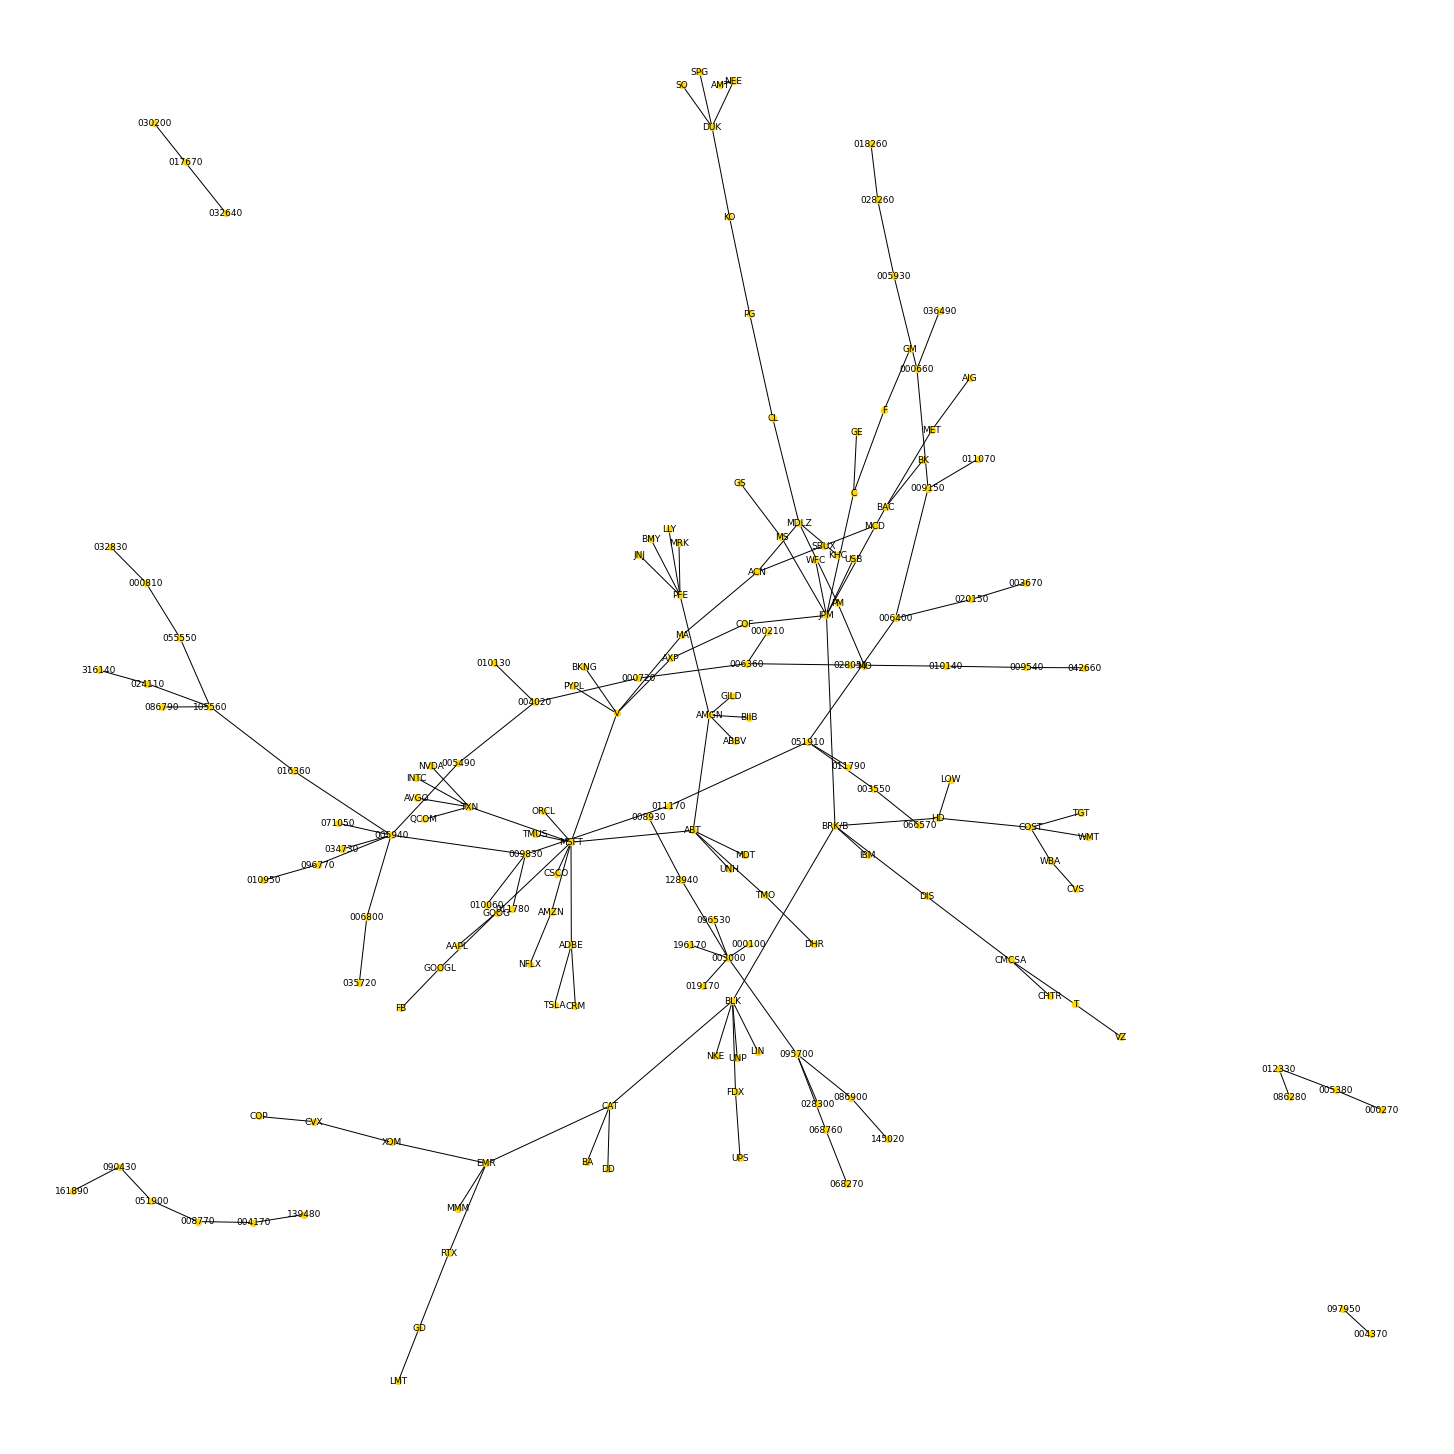

In [37]:
# before
# log return
ret = df_before.pct_change().dropna()
ret = np.log(1+ret)

# correlation matrix
corr = ret.corr()

# correlation to distance/weight
hurdle = 0.3 # correlation hurdle
thres = np.sqrt((1.-hurdle)*2) # threshold distance 

dist = np.sqrt(np.clip((1.-corr)*2., a_min=0.0, a_max=4.0))
dist[dist>thres] = 0

weight = 1./dist
weight = weight.replace([np.inf, -np.inf], 0.)

# distance/weight matrix to edgelist
edge_dist = dist.stack().reset_index()
edge_dist = edge_dist.rename(columns={"level_0":"source", "level_1":"target", 0:"distance"})
edge_dist = edge_dist[edge_dist['distance']>0.]
edge_wgt = weight.stack().reset_index()
edge_wgt = edge_wgt.rename(columns={"level_0":"source", "level_1":"target", 0:"weight"})
edge_wgt = edge_wgt[edge_wgt['weight']>0.]

edgelist = pd.merge(edge_dist,edge_wgt)

edgelist = edgelist[['source', 'target', 'distance']]

G = nx.from_pandas_edgelist(edgelist, edge_attr=True)
nx.info(G)


## 간단 시각화
T = nx.minimum_spanning_tree(G, weight = "distance")
nx.info(T)


plt.figure(3,figsize=(20,20)) 
nx.draw(T, with_labels=True, node_size=40, node_color='gold',font_size=9)

## minimum spanning tree data 형태 확인
df_mst = pd.DataFrame(T.edges(data=True), columns = ['source', 'target', 'weight'])

## weight값 정제
df_mst['weight'] = df_mst['weight'].map(lambda x:x['distance'])

attr1 = pd.read_excel('./sna_capstone_kr.xlsx', sheet_name = 'attributes') 
attr2 = attr1.copy()

attr1.rename(columns={'id': 'source_id'}, inplace = True)
attr1.rename(columns={'name': 'source_name'}, inplace = True)
attr1.rename(columns={'sector': 'source_sector'}, inplace = True)
attr1.rename(columns={'country': 'source_country'}, inplace = True)

attr2.rename(columns={'id': 'target_id'}, inplace = True)
attr2.rename(columns={'name': 'target_name'}, inplace = True)
attr2.rename(columns={'sector': 'target_sector'}, inplace = True)
attr2.rename(columns={'country': 'target_country'}, inplace = True)

df_mst.rename(columns={'source': 'source_id'}, inplace = True)
df_mst.rename(columns={'target': 'target_id'}, inplace = True)

df_merge = pd.merge(df_mst, attr1, how = 'left', on = 'source_id')
df_merge2 = pd.merge(df_merge, attr2, how = 'left', on = 'target_id')

## column 정리
df_merge2 = df_merge2[['source_name', 'target_name', 'weight', 'source_sector', 'source_country', 'target_sector', 'target_country']]
df_merge2.rename(columns={'source_name': 'source', 'target_name':'target'}, inplace = True)

#Excel 추출
df_merge2.to_excel('./mst_total_before_0.3.xlsx', index=False)

### 코로나 이후 (2020년 이후)

'Name: \nType: Graph\nNumber of nodes: 184\nNumber of edges: 7078\nAverage degree:  76.9348'

1.8282846281777143
0.8875434488629746


'Name: \nType: Graph\nNumber of nodes: 184\nNumber of edges: 183\nAverage degree:   1.9891'

10.554407222618199
0.0


<Figure size 1440x1440 with 0 Axes>

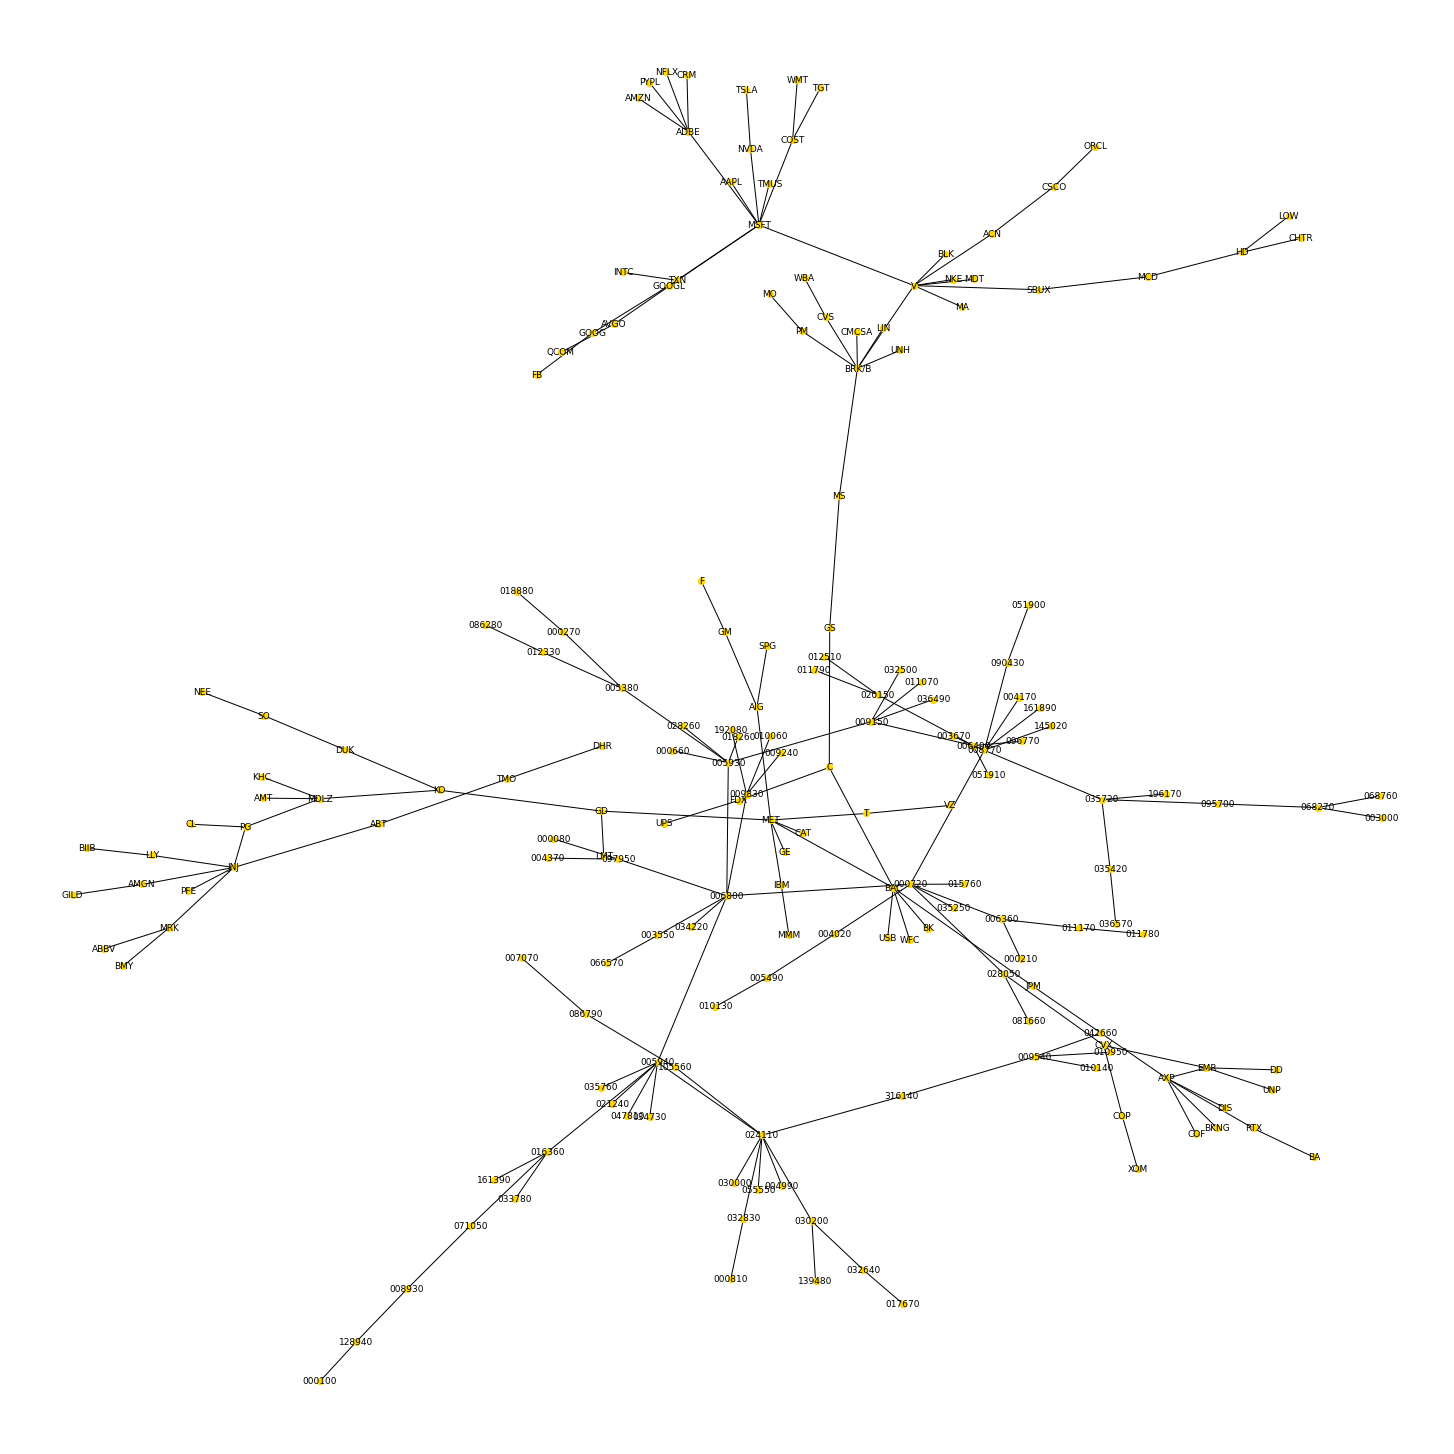

In [38]:
# after
# log return
ret = df_after.pct_change().dropna()
ret = np.log(1+ret)

# correlation matrix
corr = ret.corr()

# correlation to distance/weight
hurdle = 0.3 # correlation hurdle
thres = np.sqrt((1.-hurdle)*2) # threshold distance 

dist = np.sqrt(np.clip((1.-corr)*2., a_min=0.0, a_max=4.0))
dist[dist>thres] = 0

weight = 1./dist
weight = weight.replace([np.inf, -np.inf], 0.)

# distance/weight matrix to edgelist
edge_dist = dist.stack().reset_index()
edge_dist = edge_dist.rename(columns={"level_0":"source", "level_1":"target", 0:"distance"})
edge_dist = edge_dist[edge_dist['distance']>0.]
edge_wgt = weight.stack().reset_index()
edge_wgt = edge_wgt.rename(columns={"level_0":"source", "level_1":"target", 0:"weight"})
edge_wgt = edge_wgt[edge_wgt['weight']>0.]

edgelist = pd.merge(edge_dist,edge_wgt)

edgelist = edgelist[['source', 'target', 'distance']]

G = nx.from_pandas_edgelist(edgelist, edge_attr=True)
nx.info(G)
avg_plength = nx.average_shortest_path_length(G)
avg_cluster = nx.average_clustering(G)

print(avg_plength)
print(avg_cluster)

## 간단 시각화
T = nx.minimum_spanning_tree(G, weight = "distance")

nx.info(T)
avg_plength = nx.average_shortest_path_length(T)
avg_cluster = nx.average_clustering(T)

print(avg_plength)
print(avg_cluster)

plt.figure(3,figsize=(20,20)) 
nx.draw(T, with_labels=True, node_size=40, node_color='gold',font_size=9)

## minimum spanning tree data 형태 확인
df_mst = pd.DataFrame(T.edges(data=True), columns = ['source', 'target', 'weight'])

## weight값 정제
df_mst['weight'] = df_mst['weight'].map(lambda x:x['distance'])

attr1 = pd.read_excel('./sna_capstone_kr.xlsx', sheet_name = 'attributes') 
attr2 = attr1.copy()

attr1.rename(columns={'id': 'source_id'}, inplace = True)
attr1.rename(columns={'name': 'source_name'}, inplace = True)
attr1.rename(columns={'sector': 'source_sector'}, inplace = True)
attr1.rename(columns={'country': 'source_country'}, inplace = True)

attr2.rename(columns={'id': 'target_id'}, inplace = True)
attr2.rename(columns={'name': 'target_name'}, inplace = True)
attr2.rename(columns={'sector': 'target_sector'}, inplace = True)
attr2.rename(columns={'country': 'target_country'}, inplace = True)

df_mst.rename(columns={'source': 'source_id'}, inplace = True)
df_mst.rename(columns={'target': 'target_id'}, inplace = True)

df_merge = pd.merge(df_mst, attr1, how = 'left', on = 'source_id')
df_merge2 = pd.merge(df_merge, attr2, how = 'left', on = 'target_id')

## column 정리
df_merge2 = df_merge2[['source_name', 'target_name', 'weight', 'source_sector', 'source_country', 'target_sector', 'target_country']]
df_merge2.rename(columns={'source_name': 'source', 'target_name':'target'}, inplace = True)

#Excel 추출
df_merge2.to_excel('./mst_total_after_0.3.xlsx', index=False)